In [642]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from bound_funcs import *

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def generate_positive_semidefinite_matrix(dim, seed=None):
    """
    Generates a random positive semidefinite matrix.
    
    Parameters:
        dim (int): The dimension of the square matrix.
        seed (int, optional): A seed for the random number generator to make results reproducible.
        
    Returns:
        numpy.ndarray: A dim x dim positive semidefinite matrix.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate a random matrix A
    A = np.random.randn(dim, dim)
    
    # Multiply A by its transpose to get a symmetric and positive semidefinite matrix
    matrix = np.dot(A, A.T)
    
    # Adding a small value to the diagonal elements to ensure the matrix is positive definite
    matrix += np.eye(dim) * 1e-8
    
    return matrix

def check_p_bounds(data):
    '''Given observational data (Y,D,T) ~ p() compute bounds across measures of interest.'''
    
    Y, D, T = data['Y'], data['D'], data['T']
    Vpf_down = np.zeros((2,2))
    Vpf_up = np.zeros((2,2))
    v = np.zeros((2,2,2))

    for y in range(2):
        for d in range(2):
            for t in range(2):
                v[y,t,d] = ((Y==y) & (D==d) & (T==t)).mean()


    Vpf_up[0,1] = ((D==0) & (T==1)).mean()
    Vpf_up[1,1] = ((D==0) & (T==1)).mean()
    Vpf_up[0,0] = ((D==0) & (T==0)).mean()
    Vpf_up[1,0] = ((D==0) & (T==0)).mean()
    
    metrics = ['m_y=1', 'm_y=0', 'm_a=0', 'm_a=1', 'm_u']
    u = np.array([[1,0], [0, 1]])

    for metric in metrics:
        R_oracle = oracle_regret(v, u, metric)

        Rs_down, Rs_up = standard_bounds(v, Vpf_down, Vpf_up, u, metric)
        Rd_down, Rd_up = delta_bounds(v, Vpf_down, Vpf_up, u, metric)

        print(f'metric: {metric}')
        print(f'Standard bounds [{Rs_down:.3}, {Rs_up:.3}]')
        print(f'Delta bounds: [{Rd_down:.3}, {Rd_up:.3}]')
        print(f'Oracle: {R_oracle:.4}')
        print()

In [738]:
N = 5000
nDx = 3
nDu = 10
nD = Dx+Du
norm = 1/(2*np.sqrt(nD))

T = np.random.binomial(1,.35*np.ones(N))

dgp_assumption = 'IV'


# Instrument parameters
nz = 5             # Number of finite values
nw = 5
beta_zd = 2        # Z -> D loading (=0 ==> relevance is violated)
beta_zy = 0        # Z -> Y loading (=0 ==> exclusion restriction is satisfied)


# Sample measured and unmeasured confounders
mu, sigma = np.zeros(nD), np.eye(nD)
XU = np.random.multivariate_normal(mu, sigma, N)

# Measured and unmeasured covariate loadings
e1_coeffs = 2*np.random.rand(nD) - 1
z_coeffs = 2*np.random.rand(nD) - 1
w_coeffs = 2*np.random.rand(nD) - 1
mu1_coeffs = 2*np.random.rand(nD) - 1
mu0_coeffs = 2*np.random.rand(nD) - 1

# Zero out these terms if the IV unconfoundedness assumption is satisfied
if dgp_assumption == 'IV':
    z_coeffs[Du:] = 0

# Compute the probability distribution for Z
prob_Z = np.exp(z_coeffs*XU)
prob_Z = prob_Z / np.sum(prob_Z.sum(axis=1))  
weights = np.random.rand(nD, nz)
logits = np.dot(XU, weights)
pZ = softmax(logits)

# Sample instrument values
Z = np.argmax(np.array([np.random.multinomial(1, p) for p in pZ]), axis=1)

# Treatment propensity is a function of X, U and Z. Beta is a scaling factor.
pD = sigmoid(norm * ((e1_coeffs * XU).sum(axis=1) + beta_zd * Z))
D = np.random.binomial(1, pD)


# Compute the probability distribution for W
# prob_W = np.exp(w_coeffs*XU)
# prob_W = prob_W / np.sum(prob_W.sum(axis=1))  
# weights = np.random.rand(nD, nW)
# logits = np.dot(XU, weights)
# pW = softmax(logits)
# W = np.argmax(np.array([np.random.multinomial(1, p) for p in pW]), axis=1)

p_mu_1 = sigmoid(norm * ((mu1_coeffs * XU).sum(axis=1) + beta_zy*Z))
p_mu_0 = sigmoid(norm * ((mu0_coeffs * XU).sum(axis=1) + beta_zy*Z))
p_mu = pD*p_mu_1 + (1-pD)*p_mu_0

Y = np.random.binomial(1, p_mu)


data = {
    'Y': Y,
    'D': D,
    'X': X,
    'Z': Z
}

# return data


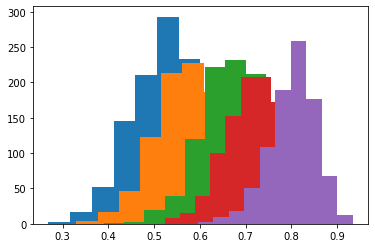

In [739]:

for z in range(nz):
    plt.hist(pD[Z==z])

In [740]:

mu_down_z = np.zeros((nz, N))
mu_up_z = np.zeros((nz, N))

# Compute upper and lower bounds on mu(a,x)
for z in range(nz):
    e1_z = sigmoid(norm * ((e1_coeffs * XU).sum(axis=1) + beta_zd * z))
    e0_z = 1-e1_z

    mu_down_z[z] = e1_z*p_mu_1
    mu_up_z[z] = e0_z + e1_z*p_mu_1

mu_down = mu_down_z.max(axis=0)
mu_up = mu_up_z.min(axis=0)

e1 = sigmoid(norm * ((e1_coeffs * XU).sum(axis=1) + beta_zd * Z))

v110_up = (T * (mu_up - p_mu_1 * e1)).mean()
v100_up = ((1-T) * (mu_up - p_mu_1 * e1)).mean()

v110_down = (T * (mu_down - p_mu_1 * e1)).mean()
v100_down = ((1-T) * (mu_down - p_mu_1 * e1)).mean()

    

Vpf_down = np.zeros((2,2))
Vpf_up = np.zeros((2,2))
v = np.zeros((2,2,2))

for y in range(2):
    for d in range(2):
        for t in range(2):
            v[y,t,d] = ((Y==y) & (D==d) & (T==t)).mean()


Vpf_up[0,1] = v110_up
Vpf_up[1,1] = v110_up
Vpf_up[0,0] = v100_up
Vpf_up[1,0] = v100_up            

Vpf_down[0,1] = v110_down
Vpf_down[1,1] = v110_down
Vpf_down[0,0] = v100_down
Vpf_down[1,0] = v100_down


    
metrics = ['m_y=1', 'm_y=0', 'm_a=0', 'm_a=1', 'm_u']
u = np.array([[1,0], [0, 1]])

for metric in metrics:
    R_oracle = oracle_regret(v, u, metric)

    Rs_down, Rs_up = standard_bounds(v, Vpf_down, Vpf_up, u, metric)
    Rd_down, Rd_up = delta_bounds(v, Vpf_down, Vpf_up, u, metric)

    print(f'metric: {metric}')
    print(f'Standard bounds [{Rs_down:.3}, {Rs_up:.3}]')
    print(f'Delta bounds: [{Rd_down:.3}, {Rd_up:.3}]')
    print(f'Oracle: {R_oracle:.4}')
    print()

metric: m_y=1
Standard bounds [-0.544, -0.0862]
Delta bounds: [-0.455, -0.186]
Oracle: -0.2884

metric: m_y=0
Standard bounds [-0.558, -0.0978]
Delta bounds: [-0.473, -0.195]
Oracle: -0.3

metric: m_a=0
Standard bounds [-0.372, 0.393]
Delta bounds: [-0.172, 0.193]
Oracle: 0.003315

metric: m_a=1
Standard bounds [-0.0934, 0.106]
Delta bounds: [-0.0934, 0.106]
Oracle: 0.00942

metric: m_u
Standard bounds [-0.196, 0.204]
Delta bounds: [-0.066, 0.0744]
Oracle: 0.0038



## Now, given these nuisance functions, we'd like to estimate Vpf.

## Test computing bounds from the sampled joint distribution

In [643]:
data = {
    'Y': Y, 
    'D': D, 
    'T': T
}

check_p_bounds(data)

metric: m_y=1
Standard bounds [-0.653, 0.177]
Delta bounds: [-0.494, 0.0182]
Oracle: -0.1591

metric: m_y=0
Standard bounds [-0.691, 0.143]
Delta bounds: [-0.55, -0.0126]
Oracle: -0.186

metric: m_a=0
Standard bounds [-0.641, 0.672]
Delta bounds: [-0.322, 0.357]
Oracle: 0.01164

metric: m_a=1
Standard bounds [-0.156, 0.195]
Delta bounds: [-0.158, 0.195]
Oracle: 0.01454

metric: m_u
Standard bounds [-0.317, 0.352]
Delta bounds: [-0.156, 0.191]
Oracle: 0.0138



## Scratch stuff


In [456]:
# Creating the Logistic Regression model
model = LogisticRegression()

# Fitting the model
model.fit(XU, D)

# Making predictions and evaluating the model
predictions = model.predict_proba(XU)
accuracy = accuracy_score(D, predictions)
print(f"Accuracy: {accuracy}")
predictions

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets